### Contents

#### 1) Load & Join Data

#### 2) Data pre-processing
* 2.1) Missing Data
    * 2.1.1) Imputing Missing data (Explore Item data)
* 2.2) Rollup data at impression_id
    * 2.2.1) Item_Price & Counts of View Log
    * 2.2.2) Category 1, 2 & 3 and Product Type
    * 2.2.3) Device_Type
    * 2.2.4) Merge rolledup view log & item data with Train+Test data

#### 3) EDA (for view log & item data)
* 3.1) Item Price
* 3.2) Flag: # log views within last 15 days (before impression date)
* 3.3) Device Type
* 3.4) Product Category & Type
* 3.5) Final Columns (from view log & item data)

#### 4) EDA (for impression train data)
* 4.1) Impression_Time
    * 4.1.1) Get hour, weekday, day name from impression_time
    * 4.1.2) Clicks & CTR by hour
    * 4.1.3) Clicks & CTR by dayname
* 4.2) Network (is_4G) & Operating system (os_version)
* 4.3) Partner websites / Apps (app_code)

#### 5) Feature engineering

#### 6) Feature Importance

#### 7) Simple model

#### 8) Fitting Hypertuned Model

* 8.1) Logistic Regression
* 8.2) Light GBM (Gradient Boosting Machine) Classifier
* 8.3) xgBoost
* 8.4) Random Forest

#### 9) Linear Discriminant Analysis (LDA) (with logistic regression & random forest)

#### 10) Resampling techniques

#### 11) Final best fitted model

In [1]:
# Loading all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, KFold
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import datetime,time
import warnings
warnings.filterwarnings("ignore")

%cd D:\IPython Jupyter\Analytics Vidya Datasets\WNS Wizard 2019

D:\IPython Jupyter\Analytics Vidya Datasets\WNS Wizard 2019


### 1) Load & Join Data

In [2]:
# Loading data
df_train = pd.read_csv("WNS_train.csv")
df_test = pd.read_csv("WNS_test.csv")
df_view_log = pd.read_csv("WNS_view_log.csv")                    # data is not unique at any level
df_item_data = pd.read_csv("WNS_item_data.csv")

print("Train Data:",df_train.shape, df_train.columns)
print("Test Data:",df_test.shape, df_test.columns)
print("View Log Data:",df_view_log.shape, df_view_log.columns)
print("Item Data:",df_item_data.shape, df_item_data.columns)

Train Data: (237609, 7) Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version',
       'is_4G', 'is_click'],
      dtype='object')
Test Data: (90675, 6) Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version',
       'is_4G'],
      dtype='object')
View Log Data: (3118622, 5) Index(['server_time', 'device_type', 'session_id', 'user_id', 'item_id'], dtype='object')
Item Data: (132761, 6) Index(['item_id', 'item_price', 'category_1', 'category_2', 'category_3',
       'product_type'],
      dtype='object')


In [3]:
df_test['is_click'] = 'NA'
df_com = df_train.append(df_test, ignore_index=True)
print(df_com.shape)

(328284, 7)


In [4]:
# dates loaded as object, let's convert back them to date datatype & check
df_com['impression_time'] = df_com['impression_time'].astype('datetime64[ns]')
df_view_log['server_time'] = df_view_log['server_time'].astype('datetime64[ns]')

In [5]:
# merging train+test data with view log
print("Unique user_id from train+test data:",df_com['user_id'].unique().shape)
print("Unique user_id from view_log data:", df_view_log['user_id'].unique().shape)

df_com1 = df_com.merge(df_view_log,on='user_id',how='left')
print("Total shape for train+test+log data:",df_com1.shape)
print("# missing datapoints",df_com1.isnull().sum().sum())

Unique user_id from train+test data: (89157,)
Unique user_id from view_log data: (89157,)
Total shape for train+test+log data: (14924579, 11)
# missing datapoints 0


In [6]:
# Column 'item_id' from both view_log & item data
print("Unique item_id from train+test data:",df_com1['item_id'].unique().shape)
print("Unique item_id from view_log data:", df_item_data['item_id'].unique().shape)

temp1 = pd.DataFrame(df_com1['item_id'].unique(),columns=['view'])
temp1['C1'] = 1
temp2 = pd.DataFrame(df_item_data['item_id'].unique(),columns=['view'])
temp2['C2'] = 1

temp3 = temp1.merge(temp2,how='left',on='view')
print("Unique items which are missing in item_data, but present in view_log_data",'\n',temp3.isnull().sum())

temp4 = temp1.merge(temp2,how='right',on='view')
print("Unique items which are missing in view_log_data, but present in item_data",'\n',temp4.isnull().sum())

Unique item_id from train+test data: (126708,)
Unique item_id from view_log data: (132761,)
Unique items which are missing in item_data, but present in view_log_data 
 view      0
C1        0
C2      101
dtype: int64
Unique items which are missing in view_log_data, but present in item_data 
 view       0
C1      6154
C2         0
dtype: int64


* 6,154 items don't have any log files means none of the user had ever searches for these products/items. So, it's safe to ignore them
* 101 items have log files, but we don't have any information about these products/items, which accounts as missing data (item price, it's categories type). We'll explore whole data then will impute these records accordingly

In [7]:
df_com2 = df_com1.merge(df_item_data,on='item_id',how='left')
print("Total shape for train+test+log+view data:",df_com2.shape)
print("# missing datapoints",'\n',df_com2.isnull().sum())

Total shape for train+test+log+view data: (14924579, 16)
# missing datapoints 
 impression_id         0
impression_time       0
user_id               0
app_code              0
os_version            0
is_4G                 0
is_click              0
server_time           0
device_type           0
session_id            0
item_id               0
item_price         9260
category_1         9260
category_2         9260
category_3         9260
product_type       9260
dtype: int64


In [8]:
# Quality check: Number of items for which there is info about it's price, category & type (should be 101) 
df_com2[df_com2['item_price'].isna()]['item_id'].unique().shape

(101,)

### 2) Data pre-processing
* As the train+test and view log having multiple user_ids, thats why number of records looks way too high (15 million)
* So lets roll up data at impression id (where we're supposed to fit model)

In [9]:
print(df_com2.shape, '\n\n',df_com2.dtypes)

(14924579, 16) 

 impression_id              object
impression_time    datetime64[ns]
user_id                     int64
app_code                    int64
os_version                 object
is_4G                       int64
is_click                   object
server_time        datetime64[ns]
device_type                object
session_id                  int64
item_id                     int64
item_price                float64
category_1                float64
category_2                float64
category_3                float64
product_type              float64
dtype: object


In [10]:
# Flag (yes or no) if impression was created within 15 days of session time (from view log file)
from datetime import timedelta
df_com2['flag']=(df_com2['impression_time'] >= df_com2['server_time']) & ((df_com2['impression_time']  - timedelta(days=15)) <= df_com2['server_time'])

In [11]:
temp = df_com2[df_com2['flag'] == True].drop('flag',axis=1)
print("When flag = True, then it'll retain records(%):",temp.shape[0]/df_com2.shape[0]*100, temp.shape[0])

temp = df_com2[df_com2['flag'] == True][['impression_id', 'is_click']].drop_duplicates()
print("WHen flag = True, impression id retain (%):",temp['impression_id'].unique().shape[0]/df_com.shape[0]*100,
      temp['impression_id'].unique().shape[0])

When flag = True, then it'll retain records(%): 27.499971690993764 4104255
WHen flag = True, impression id retain (%): 83.91453741272801 275478


* Drop those records when this flag is false (only those information related to view log or item data will be retained which resulted in impression within last 15 days)
    * Doing so, will result in drop of 72.5% of such records, so now we'll be left with only the data, which might have any impact of impression
    * Also it will result in dropping 16.1% of impression ids (for which there was no log created in last 15 days), so we'll add these records later
* So, we'll rollup data at Impression ID using flag column

* Other than last 15 days assumption, I also tried 7 and 30 days, but 7 days was causing too much loss in records & 30 days was bringing too much noise in data. Following is comparision for retainng the data for all 3 cases. Impression id retain | All records retain
    * 7 days: 65.88% | 13.16%
    * 15days: 83.91% | 27.49%
    * 30days: 95.69% | 52.99%

#### 2.1) Missing Data

In [12]:
# Dropping records when flag is false
# Dropping columns like user id, session id, item id (no use now)
df_com3 = df_com2[df_com2['flag'] == True].drop(['user_id','session_id','item_id'],axis=1)
df_com3.shape, df_com3['impression_id'].unique().shape, df_com3.drop_duplicates().shape

((4104255, 14), (275478,), (3962547, 14))

In [13]:
df_com3.isnull().sum()

impression_id         0
impression_time       0
app_code              0
os_version            0
is_4G                 0
is_click              0
server_time           0
device_type           0
item_price         2674
category_1         2674
category_2         2674
category_3         2674
product_type       2674
flag                  0
dtype: int64

##### 2.1.1) Imputing Missing data (Explore Item data)
* 2674 records missing in variables, from item_data
* Let's explore this item data & then impute them

* As discussed earlier, following numbers are the missing # records with the respect to their last number of days assumption;
    * 7 days: 1273 missing
    * 15days: 2674 missing
    * 30days: 5085 missing

(array([1.31486e+05, 1.03400e+03, 1.64000e+02, 4.50000e+01, 1.70000e+01,
        8.00000e+00, 5.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([5.0000000e+00, 1.3408450e+05, 2.6816400e+05, 4.0224350e+05,
        5.3632300e+05, 6.7040250e+05, 8.0448200e+05, 9.3856150e+05,
        1.0726410e+06, 1.2067205e+06, 1.3408000e+06]),
 <a list of 10 Patch objects>)

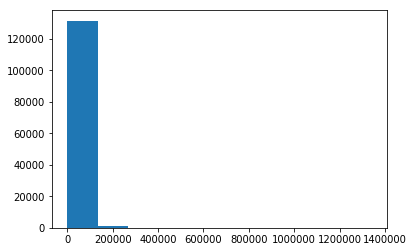

In [14]:
plt.hist(df_item_data['item_price'])

(<matplotlib.axes._subplots.AxesSubplot at 0x1b50011a240>,
 Text(0.5,1,'Counts of Category 3'))

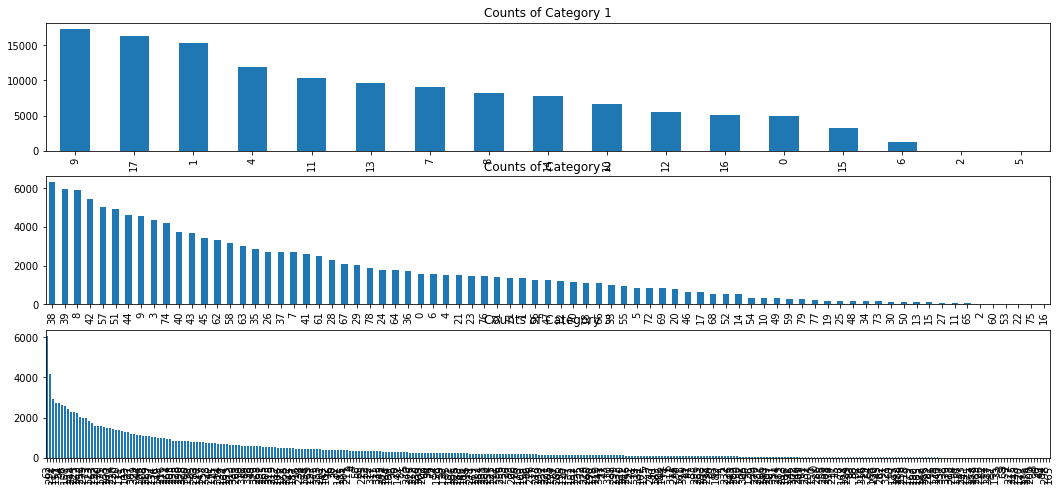

In [15]:
plt.figure(figsize=(18,8))
plt.subplot(311),df_item_data['category_1'].value_counts().plot(kind = 'bar'),plt.title('Counts of Category 1')
plt.subplot(312),df_item_data['category_2'].value_counts().plot(kind = 'bar'),plt.title('Counts of Category 2')
plt.subplot(313),df_item_data['category_3'].value_counts().plot(kind = 'bar'),plt.title('Counts of Category 3')
# plt.subplot(414),df_item_data['product_type'].value_counts().plot(kind = 'bar'),plt.title('Counts of product_type')

In [16]:
df_item_data['category_1'].unique().shape[0], df_item_data['category_2'].unique().shape[0], df_item_data['category_3'].unique().shape[0],df_item_data['product_type'].unique().shape[0]

(17, 79, 335, 7959)

In [17]:
# Top Category_2
temp = df_item_data['category_2'].value_counts().reset_index()
print("Total items covered by top 20 category_2:", temp.iloc[:20,1].sum(), "i.e.", temp.iloc[:20,1].sum()/df_item_data.shape[0]*100)
category_2_top = list(temp.iloc[:20,0])
print(len(category_2_top),category_2_top,'\n')

# Top Category_3
temp = df_item_data['category_3'].value_counts().reset_index()
print("Total items covered by top 40 category_3:", temp.iloc[:40,1].sum(), "i.e.", temp.iloc[:40,1].sum()/df_item_data.shape[0]*100)
category_3_top = list(temp.iloc[:40,0])
print(len(category_3_top),category_3_top,'\n')

# Top Product_Type
temp = df_item_data['product_type'].value_counts().reset_index()
print("Total items covered by top 200 product_type:", temp.iloc[:200,1].sum(), "i.e.", temp.iloc[:200,1].sum()/df_item_data.shape[0]*100)
product_type_top = list(temp.iloc[:200,0])
print(len(product_type_top),product_type_top,'\n')

Total items covered by top 20 category_2: 82639 i.e. 62.2464428559592
20 [38, 39, 8, 42, 57, 51, 44, 9, 3, 74, 40, 43, 45, 62, 58, 63, 35, 26, 37, 7] 

Total items covered by top 40 category_3: 72620 i.e. 54.699798886721254
40 [62, 292, 114, 151, 84, 36, 157, 159, 244, 223, 162, 252, 279, 73, 113, 263, 132, 90, 171, 233, 100, 214, 220, 20, 111, 15, 103, 27, 301, 329, 44, 199, 308, 119, 297, 134, 16, 148, 216, 271] 

Total items covered by top 200 product_type: 55590 i.e. 41.87223657550034
200 [2874, 5622, 5036, 10412, 7791, 5164, 2106, 7455, 5609, 9959, 5276, 3184, 9015, 8310, 2417, 3055, 9041, 6239, 4524, 3399, 6648, 4924, 8121, 6077, 4986, 9362, 6186, 1945, 1943, 5251, 1617, 9086, 1431, 7885, 8323, 5420, 977, 7312, 1485, 7551, 7284, 8189, 1961, 1457, 9789, 1923, 176, 10099, 4309, 9839, 2835, 4371, 3642, 8506, 1713, 6295, 986, 2099, 10333, 7632, 6827, 5403, 8765, 763, 8127, 3265, 10083, 2944, 8579, 8994, 3113, 2159, 907, 9495, 2065, 4646, 5783, 6823, 9234, 1845, 5655, 493, 9498, 491, 

* Most occruing categories & product type will cover item(%):
    * Top 20 category_2 are 62%
    * Top 40 category_3 are 55%
    * Top 200 product_type are 42%

In [18]:
df_item_data['category_1'].value_counts()[:1]                 # Most occured category_1

9    17343
Name: category_1, dtype: int64

* Item price is highly right skewed, it won't be good idea to impute missing data with median/mean value
* However, mode of category_1 is 9 (most occurance), applying this condition, we'll repace;
    * item price with median
    * category_1, category_2, category_3 & product_type with mode

In [19]:
item_category_1 = int(df_item_data['category_1'].mode())
temp = df_item_data[df_item_data['category_1'] == item_category_1]

item_price_impute = temp['item_price'].median()
item_category_2 = int(temp['category_2'].mode())
item_category_3 = int(temp['category_3'].mode())
item_product_type = int(temp['product_type'].mode())

print(item_price_impute, item_category_1, item_category_2, item_category_3, item_product_type)

4196.0 9 44 114 7791


In [20]:
# as we discovered above during item_data exploration, we'll impute missing data here accordingly
df_com3['item_price'].fillna(item_price_impute,inplace=True)
df_com3['category_1'].fillna(item_category_1,inplace=True)
df_com3['category_2'].fillna(item_category_2,inplace=True)
df_com3['category_3'].fillna(item_category_3,inplace=True)
df_com3['product_type'].fillna(item_product_type,inplace=True)

print("# missing data:",df_com3.isnull().sum().sum())

# missing data: 0


In [21]:
df_com3.shape, df_com3.columns

((4104255, 14),
 Index(['impression_id', 'impression_time', 'app_code', 'os_version', 'is_4G',
        'is_click', 'server_time', 'device_type', 'item_price', 'category_1',
        'category_2', 'category_3', 'product_type', 'flag'],
       dtype='object'))

#### 2.2) Rollup data at impression_id

* Data has duplicates in view log file, that only can happen when user clicked twice in a give second, so we'll treat these records as separte entity
* Roll up at impression id;
    * Count of log views generated in last 15 days
    * item price: groupby at impression_id level
    * devive_type (unique = 3); crosstab counts
    * category_1 (unique = 18); crosstab counts
    * category_2 & category_3;
        * There are way too many sub-categories here, so we'll ignore them as it'll only going to increase noise in data
        * Taking top 20 from category_2 & top 40 category_3
    * product_type; (unique = ~6k from ~8k, which logged in last 15 days)
        * Either we'll ignore this for now
        * Or take top 200 product types

In [22]:
# Column wise unique items 
for i in df_com3.columns.tolist():
    print(i,len(df_com3[i].unique()))

impression_id 275478
impression_time 44139
app_code 495
os_version 3
is_4G 2
is_click 3
server_time 59449
device_type 3
item_price 10724
category_1 16
category_2 78
category_3 330
product_type 6783
flag 1


##### 2.2.1) Item_Price & Counts of View Log

In [23]:
df_com4 = df_com3.groupby('impression_id')['item_price','flag'].agg('sum').reset_index()
df_com4.shape, df_com4.columns

((275478, 3), Index(['impression_id', 'item_price', 'flag'], dtype='object'))

##### 2.2.2) Category 1, 2 & 3 and Product Type

In [24]:
temp = pd.crosstab(df_com3['impression_id'],df_com3['category_1']).reset_index()                # 16 unique category_1 (5th catgory dropped)
df_com4 = df_com4.merge(temp,how='left',on='impression_id')
df_com4.columns = ['C1'+'_'+str(i) if "0" in str(i) else i for i in list(df_com4.columns)]
print(df_com4.shape, df_com4.columns)

(275478, 19) Index(['impression_id', 'item_price', 'flag', 'C1_0.0', 'C1_1.0', 'C1_2.0',
       'C1_4.0', 'C1_6.0', 'C1_7.0', 'C1_8.0', 'C1_9.0', 'C1_10.0', 'C1_11.0',
       'C1_12.0', 'C1_13.0', 'C1_14.0', 'C1_15.0', 'C1_16.0', 'C1_17.0'],
      dtype='object')


In [25]:
# Adding new column with most occured categories
df_com3['category_2_new'] = df_com3['category_2'].apply(lambda x: "C2"+"_"+str(x) if x in category_2_top else None)
df_com3['category_3_new'] = df_com3['category_3'].apply(lambda x: "C3"+"_"+str(x) if x in category_3_top else None)
df_com3['product_type_new'] = df_com3['product_type'].apply(lambda x: "PT"+"_"+str(x) if x in product_type_top else None)

df_com3['category_2_new'].unique().shape, df_com3['category_3_new'].unique().shape, df_com3['product_type_new'].unique().shape

((21,), (41,), (201,))

In [26]:
temp = pd.crosstab(df_com3['impression_id'],df_com3['category_2_new']).reset_index()
df_com4 = df_com4.merge(temp,how='left',on='impression_id')
print(df_com4.shape)

temp = pd.crosstab(df_com3['impression_id'],df_com3['category_3_new']).reset_index()
df_com4 = df_com4.merge(temp,how='left',on='impression_id')
print(df_com4.shape)

temp = pd.crosstab(df_com3['impression_id'],df_com3['product_type_new']).reset_index()
df_com4 = df_com4.merge(temp,how='left',on='impression_id')
df_com4.shape

(275478, 39)
(275478, 79)


(275478, 279)

##### 2.2.3) Device_Type

In [27]:
temp = pd.crosstab(df_com3['impression_id'],df_com3['device_type']).reset_index()                # 3 unique category_1 (5th catgory dropped)
df_com4 = df_com4.merge(temp,how='left',on='impression_id')
print(df_com4.shape, df_com4.columns)

(275478, 282) Index(['impression_id', 'item_price', 'flag', 'C1_0.0', 'C1_1.0', 'C1_2.0',
       'C1_4.0', 'C1_6.0', 'C1_7.0', 'C1_8.0',
       ...
       'PT_9713.0', 'PT_977.0', 'PT_9789.0', 'PT_9839.0', 'PT_986.0',
       'PT_9939.0', 'PT_9959.0', 'android', 'iphone', 'web'],
      dtype='object', length=282)


##### 2.2.4) Merge rolledup view log & item data with Train+Test data

In [28]:
df_com5 = df_com.merge(df_com4,how='left',on='impression_id')
print(df_com5.shape,df_com5.columns)
df_com5.head()

(328284, 288) Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version',
       'is_4G', 'is_click', 'item_price', 'flag', 'C1_0.0',
       ...
       'PT_9713.0', 'PT_977.0', 'PT_9789.0', 'PT_9839.0', 'PT_986.0',
       'PT_9939.0', 'PT_9959.0', 'android', 'iphone', 'web'],
      dtype='object', length=288)


,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,item_price,flag,C1_0.0,...,PT_9713.0,PT_977.0,PT_9789.0,PT_9839.0,PT_986.0,PT_9939.0,PT_9959.0,android,iphone,web
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,37528.0,11.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,53210.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0


In [29]:
df_nodata = df_com5[df_com5['flag'].isna()]
print(df_nodata.shape)
df_nodata['is_click'].value_counts()

(52806, 288)


0     27283
NA    24945
1       578
Name: is_click, dtype: int64

* As said earlier, for 16.1% of impression_id, there is no log view generated in last 15 days. So, the biggest challenge with this data now is;
    * we can't drop these records
    * we can't impute them
* Looks like, half of this missing impressions belongs to test data and only 1% (578 cases) of train data says user clicked on these impressions (where we don't have any record of log view in last 15 days) 
* Let's explore this set of data, to answere this question that how to deal with these missing part

In [30]:
df_com5[df_com5['flag'].isna()==False]['is_click'].value_counts()

0     199464
NA     65730
1      10284
Name: is_click, dtype: int64

* Good part is we have view_log data for 10284 cases (out of 10862 clicks), where user clicked on impression
* So, we simply replace missing data with 0, because thats what it will count here. i.e. No view_log generated in last 15 days
* And if there is any pattern for this missing data, will be covered with 'app_code', 'os_version' & 'is_4G'. So, next we'll see how to deal with these 3 variables

### 3.) EDA (for view log & item data)

In [31]:
# replaceing missing data with 0 (for 34% of impressions; to log file in last 7 days)
df_com5.fillna(0,inplace=True)
df_com5.isnull().sum().sum()

0

In [32]:
df_com5.shape, df_com5.columns

((328284, 288),
 Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version',
        'is_4G', 'is_click', 'item_price', 'flag', 'C1_0.0',
        ...
        'PT_9713.0', 'PT_977.0', 'PT_9789.0', 'PT_9839.0', 'PT_986.0',
        'PT_9939.0', 'PT_9959.0', 'android', 'iphone', 'web'],
       dtype='object', length=288))

#### 3.1) Item Price

(<matplotlib.axes._subplots.AxesSubplot at 0x1b501737c50>,
 Text(0.5,1,'Log transformation'))

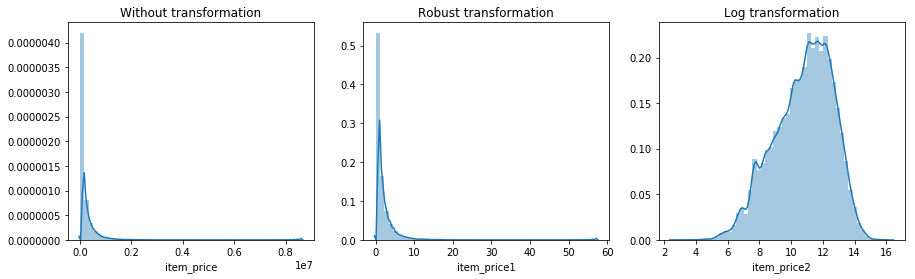

In [33]:
# Treating outliers with robust scaling vs log transformation
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df_com5['item_price1'] = scaler.fit_transform(df_com5[['item_price']])                      # Robust transformation

df_com5['item_price2'] = np.log(df_com5['item_price'])                                      # Log transformation
df_com5['item_price2'].replace([np.inf, -np.inf], 0, inplace = True)                        # replacing inf with 0 (n/a cases)

plt.figure(figsize=(15,4))
plt.subplot(131),sns.distplot(df_com5[df_com5['item_price']>0]['item_price']), plt.title('Without transformation')
plt.subplot(132),sns.distplot(df_com5[df_com5['item_price1']>0]['item_price1']), plt.title('Robust transformation')
plt.subplot(133),sns.distplot(df_com5[df_com5['item_price2']>0]['item_price2']), plt.title('Log transformation')

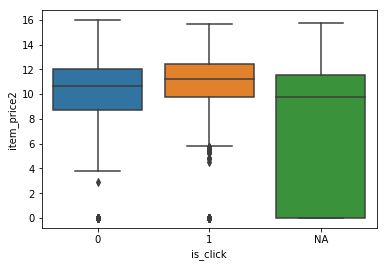

In [34]:
sns.boxplot(x=df_com5['is_click'],y=df_com5['item_price2'])

* High product price seems to have a good relationship with clicking on impression

#### 3.2) Flag: # log views within last 15 days (before impression date)

(<matplotlib.axes._subplots.AxesSubplot at 0x1b5017f9e48>,
 Text(0.5,1,'Log transformation'))

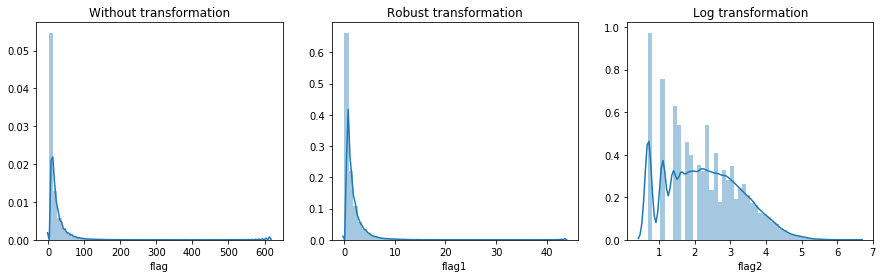

In [35]:
# Treating outliers with robust scaling vs log transformation
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df_com5['flag1'] = scaler.fit_transform(df_com5[['flag']])                      # Robust transformation

df_com5['flag2'] = np.log(df_com5['flag'])                                      # Log transformation
df_com5['flag2'].replace([np.inf, -np.inf], 0, inplace = True)                        # replacing inf with 0 (n/a cases)

plt.figure(figsize=(15,4))
plt.subplot(131),sns.distplot(df_com5[df_com5['flag']>0]['flag']), plt.title('Without transformation')
plt.subplot(132),sns.distplot(df_com5[df_com5['flag1']>0]['flag1']), plt.title('Robust transformation')
plt.subplot(133),sns.distplot(df_com5[df_com5['flag2']>0]['flag2']), plt.title('Log transformation')

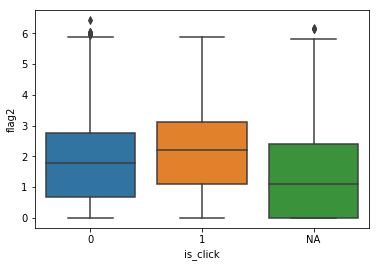

In [36]:
sns.boxplot(x=df_com5['is_click'],y=df_com5['flag2'])

* Higher log counts seems to have a good relationship with clicking on impression

#### 3.3) Device Type

In [37]:
df_view_log['device_type'].value_counts()

android    3117737
iphone         861
web             24
Name: device_type, dtype: int64

In [38]:
df_com5.groupby('is_click')[['android','iphone','web']].agg(['sum','mean'])

android            iphone             web          
                sum       mean    sum      mean   sum      mean
is_click                                                       
0         3044044.0  13.424848  611.0  0.002695  16.0  0.000071
1          202980.0  18.687166   32.0  0.002946   0.0  0.000000
NA         856196.0   9.442470  362.0  0.003992  14.0  0.000154

* In view_log file, 99.97% of device types are android
* After rolling up at impression_id, only android class seems to have some relation with is_click. As avg counts in log file is high when clicked
* So, we'll drop iphone & web variables

#### 3.4) Product Category & Type

In [39]:
df_com5.groupby('is_click')[list(filter(None,[i if 'C1' in i else None for i in list(df_com5.columns)]))].agg(['sum','mean']).T

is_click                  0             1             NA
C1_0.0  sum   114654.000000   7756.000000   32831.000000
        mean       0.505647      0.714049       0.362073
C1_1.0  sum   373838.000000  24634.000000  104919.000000
        mean       1.648701      2.267906       1.157089
C1_2.0  sum        1.000000      1.000000       2.000000
        mean       0.000004      0.000092       0.000022
C1_4.0  sum   268537.000000  18250.000000   82549.000000
        mean       1.184302      1.680169       0.910383
C1_6.0  sum    43180.000000   2419.000000    9773.000000
        mean       0.190433      0.222703       0.107781
C1_7.0  sum   163818.000000  11065.000000   47224.000000
        mean       0.722470      1.018689       0.520805
C1_8.0  sum   162193.000000  10957.000000   41417.000000
        mean       0.715304      1.008746       0.456763
C1_9.0  sum   406154.000000  26908.000000  111652.000000
        mean       1.791221      2.477260       1.231343
C1_10.0 sum   160242.000000  10326.000000   41323.000000
        mean       0.706700      0.950654       0.455726
C1_11.0 sum   236386.000000  15855.000000   62993.000000
        mean       1.042510      1.459676       0.694712
C1_12.0 sum   135650.000000   9003.000000   38560.000000
        mean       0.598244      0.828853       0.425255
C1_13.0 sum   246699.000000  16432.000000   69805.000000
        mean       1.087992      1.512797       0.769837
C1_14.0 sum   166402.000000  10938.000000   46981.000000
        mean       0.733866      1.006997       0.518125
C1_15.0 sum    69863.000000   4754.000000   19623.000000
        mean       0.308110      0.437673       0.216410
C1_16.0 sum   123131.000000   8155.000000   37960.000000
        mean       0.543033      0.750783       0.418638
C1_17.0 sum   373923.000000  25559.000000  108960.000000
        mean       1.649076      2.353066       1.201654

* From this groupby table, it's category id 2 can be dropped, and all others category seems to have some relationship with clicking, as mean value is higher in all categories compare to non-click cases
* But not dropping it beacause 25% CTR

In [40]:
# For first 5 category_2 only
df_com5.groupby('is_click')[list(filter(None,[i if 'C2' in i else None for i in list(df_com5.columns)]))].agg(['sum','mean']).T.head(10)

is_click                  0            1            NA
C2_26.0 sum    64776.000000  4298.000000  20217.000000
        mean       0.285675     0.395691      0.222961
C2_3.0  sum   128556.000000  8409.000000  37355.000000
        mean       0.566958     0.774167      0.411966
C2_35.0 sum    55627.000000  4110.000000  15866.000000
        mean       0.245326     0.378383      0.174977
C2_37.0 sum    49606.000000  3330.000000  15036.000000
        mean       0.218772     0.306573      0.165823
C2_38.0 sum   136855.000000  8759.000000  40592.000000
        mean       0.603558     0.806389      0.447665

In [41]:
# For first 5 category_3 only
df_com5.groupby('is_click')[list(filter(None,[i if 'C3' in i else None for i in list(df_com5.columns)]))].agg(['sum','mean']).T.head(10)

is_click                  0            1            NA
C3_100.0 sum   26849.000000  1910.000000   8196.000000
         mean      0.118410     0.175842      0.090389
C3_103.0 sum   23915.000000  1717.000000   6363.000000
         mean      0.105470     0.158074      0.070174
C3_111.0 sum   35889.000000  2551.000000  10060.000000
         mean      0.158278     0.234855      0.110946
C3_113.0 sum   47191.000000  3027.000000  14199.000000
         mean      0.208122     0.278678      0.156592
C3_114.0 sum   80333.000000  5050.000000  18407.000000
         mean      0.354285     0.464924      0.203000

In [42]:
# For first 5 product_type only
df_com5.groupby('is_click')[list(filter(None,[i if 'PT' in i else None for i in list(df_com5.columns)]))].agg(['sum','mean']).T.head(10)

is_click                    0            1           NA
PT_10025.0 sum   19269.000000  1036.000000  4688.000000
           mean      0.084980     0.095378     0.051701
PT_10083.0 sum    5525.000000   311.000000   925.000000
           mean      0.024366     0.028632     0.010201
PT_10097.0 sum    3975.000000   224.000000  1327.000000
           mean      0.017531     0.020622     0.014635
PT_10099.0 sum    7136.000000   486.000000  1039.000000
           mean      0.031471     0.044743     0.011459
PT_10215.0 sum    2044.000000   158.000000   392.000000
           mean      0.009014     0.014546     0.004323

* Similar trends is shown by other 2 categories (2&3) and product type, that average value is little on higher side for click. Though the magnitude is quite low because of high unique counts

#### 3.5) Final Columns (from view log & item data)

In [46]:
cols_dropped = ['impression_time','user_id','app_code','os_version','is_4G','is_click','item_price','flag', 'item_price1', 'flag1']
df_com6 = df_com5.drop(cols_dropped,axis=1)
df_com5.shape, df_com6.shape, df_com6.columns

((328284, 292),
 (328284, 282),
 Index(['impression_id', 'C1_0.0', 'C1_1.0', 'C1_2.0', 'C1_4.0', 'C1_6.0',
        'C1_7.0', 'C1_8.0', 'C1_9.0', 'C1_10.0',
        ...
        'PT_9789.0', 'PT_9839.0', 'PT_986.0', 'PT_9939.0', 'PT_9959.0',
        'android', 'iphone', 'web', 'item_price2', 'flag2'],
       dtype='object', length=282))

In [47]:
# Check if we still have any categorical variable other than impression id
df_com6.select_dtypes(include=np.object).columns

Index(['impression_id'], dtype='object')

### 4.) EDA (for impression train data)

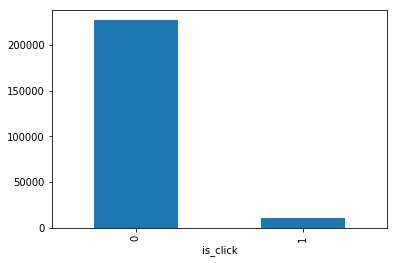

In [48]:
df_train.groupby('is_click').size().plot(kind = 'bar')                       # 4.5% click throgh rate (data imbalanced problem)

#### 4.1) Impression_Time

In [49]:
# converting time from date_hour_min_sec to date_hour (we don't need so much granularity)

df_train['impression_time'] = df_train['impression_time'].astype('datetime64[ns]')            # date time conversion
df_train['impression_time'] = df_train['impression_time'].astype('str')                       # back to string (remove minute first)
df_train['impression_time'] = df_train['impression_time'].str[:13]                            # first 13: yyyy-mm-dd hh
df_train['impression_time'] = df_train['impression_time'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H'))   # back to date

In [50]:
# Check if impression time still has seconds, minutes
sum(df_train['impression_time'].dt.minute), sum(df_train['impression_time'].dt.second)

(0, 0)

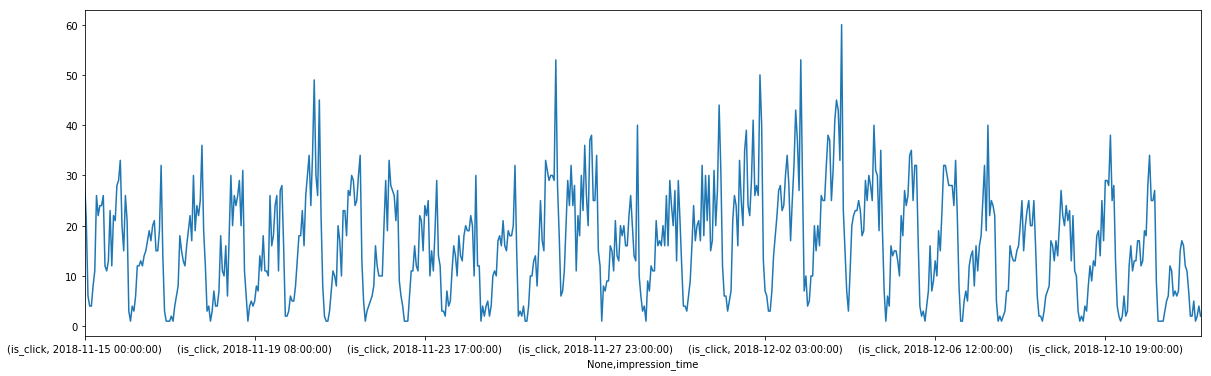

In [51]:
df_train_click = df_train[df_train['is_click']==1]
temp_click = df_train_click.groupby('impression_time').agg({'is_click' : 'sum'})
plt.figure(figsize=(20,6))
temp_click.unstack().plot()

##### 4.1.1) Get hour, weekday, day name from impression_time

In [52]:
df_train['hour_in_day'] = df_train['impression_time'].apply(lambda val : val.hour)
df_train['weekday'] = df_train['impression_time'].apply(lambda val: val.dayofweek)
df_train['day_name'] = df_train['impression_time'].apply(lambda x: x.strftime('%A'))

df_train_click['hour_in_day'] = df_train_click['impression_time'].apply(lambda val : val.hour)
df_train_click['weekday'] = df_train_click['impression_time'].apply(lambda val: val.dayofweek)
df_train_click['day_name'] = df_train_click['impression_time'].apply(lambda x: x.strftime('%A'))

df_train.columns

Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version',
       'is_4G', 'is_click', 'hour_in_day', 'weekday', 'day_name'],
      dtype='object')

In [53]:
df_train[['impression_time','is_click']].groupby(['impression_time']).sum().sort_values('is_click',ascending=False).head()

,is_click
impression_time,
2018-12-04 00:00:00,60
2018-12-03 00:00:00,53
2018-11-27 00:00:00,53
2018-12-02 00:00:00,50
2018-11-20 21:00:00,49


##### 4.1.2) Clicks & CTR by hour

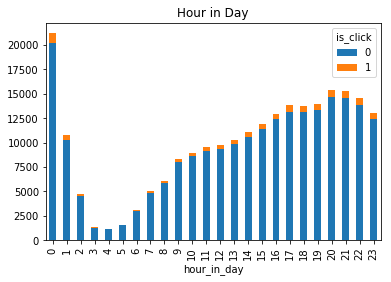

In [54]:
# uniuqe 'hour_in_day' ~ 0 TO 23 
df_train.groupby(['hour_in_day', 'is_click']).size().unstack().plot(kind='bar', stacked=True, title="Hour in Day")

(24, 4)


,hour_in_day,is_click,impression,CTR
0,0,970,21211,4.573099
21,21,785,15297,5.131725
20,20,740,15386,4.809567
19,19,686,13992,4.902802
17,17,683,13794,4.951428
22,22,669,14526,4.605535
18,18,612,13749,4.451233
23,23,610,12978,4.700262
16,16,556,12932,4.299412
15,15,530,11945,4.437003


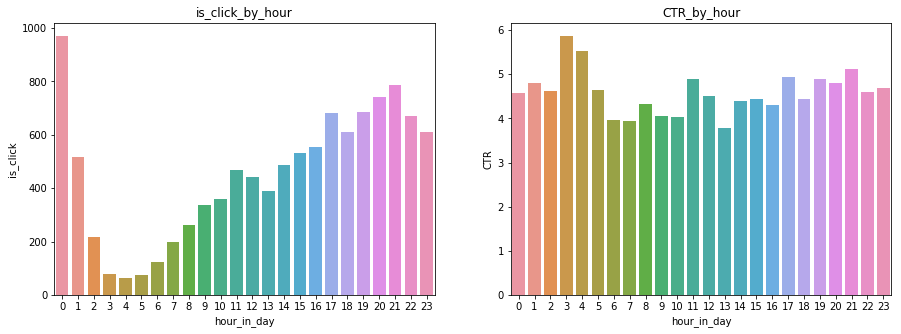

In [55]:
# clicks by hour
df_hour = pd.DataFrame(df_train.groupby('hour_in_day')['is_click'].agg('sum')).reset_index() .sort_values('is_click',ascending=False)
df_hour['impression'] = df_train['hour_in_day'].value_counts()
df_hour['CTR'] = df_hour['is_click']/df_hour['impression']*100
print(df_hour.shape)

plt.figure(figsize=(15,5))
plt.subplot(121), sns.barplot(x=df_hour['hour_in_day'],y=df_hour['is_click']),plt.title('is_click_by_hour')
plt.subplot(122), sns.barplot(x=df_hour['hour_in_day'],y=df_hour['CTR']),plt.title('CTR_by_hour')
df_hour

* Most of the clicks happened at mid-night (00) & after 20 hour)
* Least of clicks happend after 01 hour & before 07 hour

* CTR (by hour) is distributed in a range of 3.8% to 5.8%
* Maximum CTR happend at 04 hour, but impressions are least here as well

##### 4.1.3) Clicks & CTR by dayname

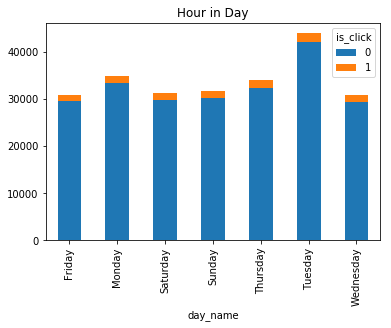

In [56]:
# uniuqe 'day_name' Sun to Mon 
df_train.groupby(['day_name', 'is_click']).size().unstack().plot(kind='bar', stacked=True, title="Hour in Day")

(7, 4)


,day_name,is_click,impression,CTR
5,Tuesday,1890,43946,4.300733
1,Monday,1632,34948,4.669795
4,Thursday,1559,33989,4.586778
3,Sunday,1520,31682,4.797677
2,Saturday,1506,31306,4.810579
0,Friday,1384,30941,4.473029
6,Wednesday,1371,30797,4.451732


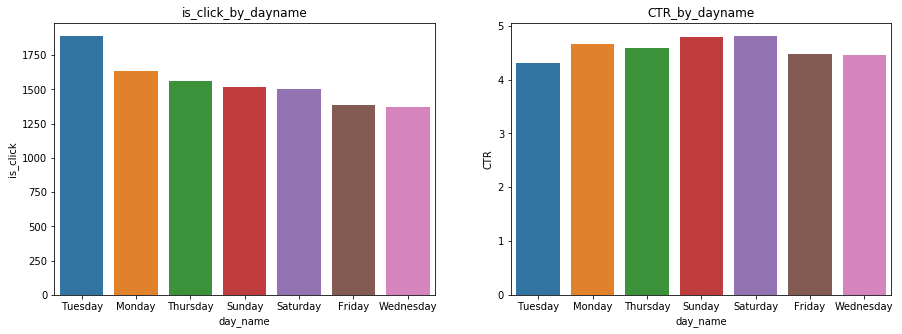

In [57]:
# clicks by day_name
df_dayname = pd.DataFrame(df_train.groupby('day_name')['is_click'].agg('sum')).reset_index() .sort_values('is_click',ascending=False)
df_dayname['impression'] = list(df_train['day_name'].value_counts())
df_dayname['CTR'] = df_dayname['is_click']/df_dayname['impression']*100
print(df_dayname.shape)

plt.figure(figsize=(15,5))
plt.subplot(121), sns.barplot(x=df_dayname['day_name'],y=df_dayname['is_click']),plt.title('is_click_by_dayname')
plt.subplot(122), sns.barplot(x=df_dayname['day_name'],y=df_dayname['CTR']),plt.title('CTR_by_dayname')
df_dayname

* Mostly clicks happend on Tuesday, though CTR is high in weekends

#### 4.2) Network (is_4G) & Operating system (os_version)

In [58]:
df_os_version = pd.crosstab(df_train['os_version'], df_train['is_click']).reset_index()
df_os_version['impression'] = df_os_version[1]/(df_os_version[0]+df_os_version[1])*100
df_os_version

is_click,os_version,0,1,impression
0,intermediate,52668,2875,5.176170
1,latest,123834,5382,4.165119
2,old,50245,2605,4.929044


In [59]:
# pd.crosstab(df_train['is_4G'], df_train['is_click'])

df_is_4G = pd.crosstab(df_train['is_4G'], df_train['is_click']).reset_index()
df_is_4G['impression'] = df_is_4G[1]/(df_is_4G[0]+df_is_4G[1])*100
df_is_4G

is_click,is_4G,0,1,impression
0,0,144738,7020,4.625786
1,1,82009,3842,4.475195


* os_version:
    * latest version is the most prominent (~50%)
    * CTR is highest when operating system is intermediate, & least in latest version
* is_4G:
    * mostly impressions & clicks are generating when 4G is network is not there (that's odd, but okay)
    * CTR is almost same, doesn't depend if network is 4G or not

#### 4.3) Partner websites / Apps (app_code)

In [60]:
# total uniuqe app_codes in train data
df_train['app_code'].unique().shape

(490,)

App code data shape: (490, 4)
App code data shape, when more than 10 clicks happend: (35, 4)


(<matplotlib.axes._subplots.AxesSubplot at 0x1b502078c88>,
 Text(0.5,1,'CTR_by_appcode'),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34]), <a list of 35 Text xticklabel objects>))

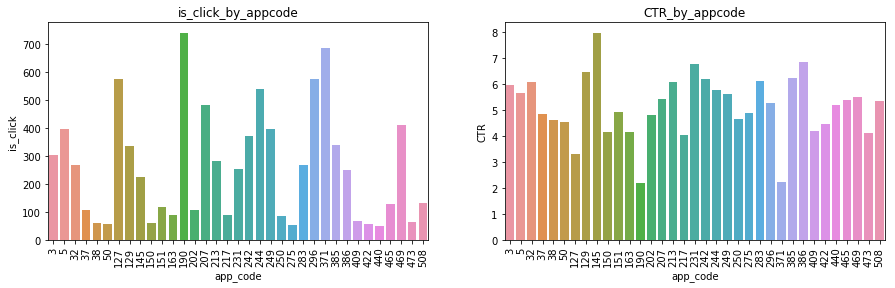

In [61]:
# clicks by app_code
df_appcode = pd.DataFrame(df_train.groupby('app_code')['is_click'].agg('sum')).reset_index() .sort_values('is_click',ascending=False)
df_appcode['impression'] = list(df_train['app_code'].value_counts())
df_appcode['CTR'] = df_appcode['is_click']/df_appcode['impression']*100
print("App code data shape:",df_appcode.shape)

df_appcode1 = df_appcode[df_appcode['is_click'] > 50].sort_values('is_click')                         # to get visibility of graph
print("App code data shape, when more than 10 clicks happend:",df_appcode1.shape)

plt.figure(figsize=(15,4))
plt.subplot(121), sns.barplot(x=df_appcode1['app_code'],y=df_appcode1['is_click']),plt.title('is_click_by_appcode'),plt.xticks(rotation=90)
plt.subplot(122), sns.barplot(x=df_appcode1['app_code'],y=df_appcode1['CTR']),plt.title('CTR_by_appcode'),plt.xticks(rotation=90)
# df_appcode1


* maximum clicks happend for app code: 190, followed by 371, and then by 127
* maximum CTR is for 145 followed by 386, and then by 231
* Range for CTR for these top app_codes is 2.2 to 7.9%

### 5.) Feature engineering
* At combined Tain & Test data from impression

In [62]:
# Loading data
df_train = pd.read_csv("WNS_train.csv")
df_test = pd.read_csv("WNS_test.csv")

print("Train Data:",df_train.shape, df_train.columns)
print("Test Data:",df_test.shape, df_test.columns)

Train Data: (237609, 7) Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version',
       'is_4G', 'is_click'],
      dtype='object')
Test Data: (90675, 6) Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version',
       'is_4G'],
      dtype='object')


In [63]:
# defining y variable: to use in final model
ytrain = df_train['is_click'].values.ravel()

df_test['is_click'] = 0
df_com = df_train.append(df_test, ignore_index=True)
print(df_com.shape), print(df_com.columns)

(328284, 7)
Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version',
       'is_4G', 'is_click'],
      dtype='object')


(None, None)

* Based on above EDA,
    * app_code: choose only those where is_click's counts > 5
    * os_version: all 3 values (old, latest, intermediate)
    * hour_in_day: all 24 hours
    * day_name: all 7 days

In [64]:
# converting time from date_hour_min_sec to date_hour (we don't need so much granularity)

df_com['impression_time'] = df_com['impression_time'].astype('datetime64[ns]')            # date time conversion
df_com['impression_time'] = df_com['impression_time'].astype('str')                       # back to string (remove minute first)
df_com['impression_time'] = df_com['impression_time'].str[:13]                            # first 13: yyyy-mm-dd hh
df_com['impression_time'] = df_com['impression_time'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H'))   # back to date

In [65]:
df_com['hour_in_day'] = df_com['impression_time'].apply(lambda val : val.hour)
df_com['weekday'] = df_com['impression_time'].apply(lambda val: val.dayofweek)
df_com['day_name'] = df_com['impression_time'].apply(lambda x: x.strftime('%A'))

In [66]:
temp = pd.DataFrame(df_com.groupby('app_code')['is_click'].agg('sum')).reset_index()
lst_app_codes = list(temp[temp['is_click'] > 5]['app_code'])
print('unique app_codes:',len(lst_app_codes))
df_com['app_code1'] = df_com['app_code'].apply(lambda x: x if x in lst_app_codes else 0)
df_com['app_code1'].unique().shape

unique app_codes: 118


(118,)

In [67]:
# One hot encoding for most occurance values
cols_one_hot_encoding = ['app_code1', 'os_version', 'hour_in_day', 'day_name']
for c in cols_one_hot_encoding:
    temp = pd.get_dummies(df_com[c],prefix=c)
    df_com = df_com.join(temp)
    print(df_com.shape)

(328284, 129)
(328284, 132)
(328284, 156)
(328284, 163)


In [68]:
# Drop columns (as discovered through impression data's exploration)
cols_drop = ['impression_time','user_id', 'app_code','app_code1', 'os_version','hour_in_day', 'weekday', 'day_name']
df_com1 = df_com.drop(cols_drop,axis=1)
df_com1.shape, df_com1.columns

((328284, 155),
 Index(['impression_id', 'is_4G', 'is_click', 'app_code1_0', 'app_code1_2',
        'app_code1_3', 'app_code1_5', 'app_code1_7', 'app_code1_9',
        'app_code1_14',
        ...
        'hour_in_day_21', 'hour_in_day_22', 'hour_in_day_23', 'day_name_Friday',
        'day_name_Monday', 'day_name_Saturday', 'day_name_Sunday',
        'day_name_Thursday', 'day_name_Tuesday', 'day_name_Wednesday'],
       dtype='object', length=155))

### 6) Feature Importance

In [69]:
# Merging final columns from impression's & view_log, item's data
df_final_com = df_com1.merge(df_com6,how='left',on='impression_id')
df_final_com.shape

(328284, 436)

In [74]:
# RandomForestClassifier
train = df_final_com.iloc[:237609,:]
xtrain, xtest, ytrain, ytest = train_test_split(train, df_train['is_click'].values.ravel(), random_state=42, test_size=0.1)
s = time.time()
rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rnd_clf.fit(xtrain, ytrain)
e = time.time()
e-s

66.9306526184082

In [76]:
features = list(train.columns)
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)
# plt.figure(figsize=(10,35))
# plt.title('Feature Importances')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), [features[i] for i in indices])
# plt.xlabel('Relative Importance')
# plt.show()

In [77]:
df_RF_Imp = pd.DataFrame({'imp':importances[indices],'Feature':[features[i] for i in indices]})
df_RF_Imp = df_RF_Imp.sort_values('imp',ascending=False)
df_RF_Imp['%age_Imp'] = df_RF_Imp['imp'].apply(lambda x: x/df_RF_Imp['imp'].sum()*100).cumsum()
df_RF_Imp.head(10)

,Feature,imp,%age_Imp
173,item_price2,0.096809,9.680929
172,android,0.049724,14.653324
171,flag2,0.049146,19.567958
170,C1_9.0,0.032834,22.851384
169,C1_1.0,0.032205,26.071883
168,C1_17.0,0.030832,29.155064
167,C1_4.0,0.028608,32.015843
166,C1_13.0,0.027666,34.782484
165,C1_11.0,0.027074,37.489848
164,C1_14.0,0.023774,39.867228


In [78]:
print("Number of feature to cover 95% of importance:",df_RF_Imp[df_RF_Imp['%age_Imp'] < 95].shape[0])

Number of feature to cover 95% of importance: 82


* Importance of variables are in the following order (in explaining if user'll click or not)
    * Item price, count of view logs in last 15 days, device type, product's category1 type
    * Weekday & Hour
    * Websites / App codes
    * Least important variables are category2,category3 & product type

In [81]:
# Dropping least important variables
cols_dropped = ['impression_id','is_click','iphone','web']
cols_dropped.extend(list(filter(None,[i if ('C2' in i)|('C3' in i)|('PT' in i) else None for i in list(df_com5.columns)])))
df_final_com = df_com1.merge(df_com6,how='left',on='impression_id').drop(cols_dropped,axis=1)

### 7.) SImple model

In [84]:
# splitting data into training and validation set
xtrain, xtest, ytrain, ytest = train_test_split(train, df_train['is_click'].values.ravel(), random_state=42, test_size=0.2)

def simple_model(alg):
    model = alg
    model.fit(xtrain, ytrain) # training the model
    ypred = model.predict_proba(xtest)[::,1]                 # predicting on the validation set
    auc = roc_auc_score(ytest, ypred)                        # AUC
    print("Area Under the Curve:",auc)

In [85]:
algs = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),LGBMClassifier(),AdaBoostClassifier(),XGBClassifier()]
algs_lst = ['LR','DTC','RFC','ABC','LGBMC','XGBC']
for alg,l in zip(algs,algs_lst):
    print(l)
    simple_model(alg=alg)

LR
Area Under the Curve: 0.7157254663540902
DTC
Area Under the Curve: 0.5301420086481233
RFC
Area Under the Curve: 0.6040926490785542
ABC
Area Under the Curve: 0.716160332566733
LGBMC
Area Under the Curve: 0.7084732113220074
XGBC
Area Under the Curve: 0.7065186760122992


* Logistic regression, light GBM, adaptive boosting & xgboost are doing good, with approximately 0.71 area under the curve
* Further we'll hypertune the parameters of these classifiers

### 8.) Fitting Hypertuned Model

#### 8.1) Logistic Regression

In [86]:
s = time.time()

train = df_final_com.iloc[:237609,:]
xtrain, xtest, ytrain, ytest = train_test_split(train, df_train['is_click'].values.ravel(), random_state=42, test_size=0.2)
print(xtrain.shape)

model = LogisticRegression(penalty='l2',class_weight='balanced')
grid = {'C':[0.1,0.5,0.8]
#         'penalty':['l2'],
#         'class_weight':['balanced']
       }
# cv = KFold(n_splits = 10, shuffle=True, random_state = 7)
clf = RandomizedSearchCV(model, grid, n_jobs=8, cv=None,scoring='roc_auc')
clf.fit(xtrain, ytrain)

e = time.time()
print(e-s)

(190087, 174)
220.63389205932617


In [87]:
clf.best_score_, clf.best_params_

(0.7099246279639512, {'C': 0.1})

In [88]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for m,s,p in zip(means,stds,params):
    print(m,s,p)

0.7099246279639512 0.0032062168070945743 {'C': 0.1}
0.7098776847997504 0.0031231729467149686 {'C': 0.5}
0.7098391791810359 0.003083526141791481 {'C': 0.8}


* Paramter C: I've tried its value ranging from 0.0001 to 10. f1-score score goes up very slightly from 0.12 to 0.14, though, AUC is same 0.72 for all values. Increasing C value more may result into overfitting & also it is taking ~10 minutes for fitting model at C = 10 
* Paramter penalty: 'l1' or 'l2' both working equally good. l2 is faster
* class: 'balanced', since data is imbalanced

f1_score: 0.14025444390265526
Accuracy on train data: 0.5877150988757779
Accuracy on test data: 0.5918732376583478
              precision    recall  f1-score   support

           0       0.98      0.58      0.73     45384
           1       0.08      0.74      0.14      2138

    accuracy                           0.59     47522
   macro avg       0.53      0.66      0.44     47522
weighted avg       0.94      0.59      0.71     47522

col_0      0     1
row_0             
0      26545   556
1      18839  1582
Area Under the Curve: 0.7154158642426329


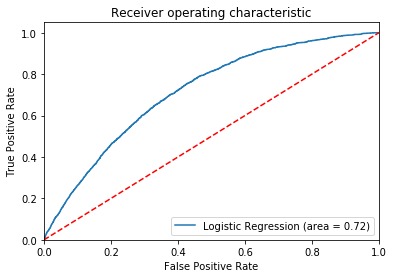

In [89]:
train = df_final_com.iloc[:237609,:]
xtrain, xtest, ytrain, ytest = train_test_split(train, df_train['is_click'].values.ravel(), random_state=42, test_size=0.2)
model = LogisticRegression(C=0.9,penalty='l2', class_weight='balanced',random_state=29)
model.fit(xtrain, ytrain)

# PREDICTION
ypred = model.predict(xtest)

# F1-SCORE, ACCURACY
print("f1_score:",f1_score(ytest, ypred))                       # calculating f1 score
print("Accuracy on train data:",model.score(xtrain,ytrain))
print("Accuracy on test data:",model.score(xtest,ytest))

# CLASSIFICATION REPORT
print(classification_report(ytest,ypred))

# CONFUSION MATRIX
print(pd.crosstab(ypred,ytest))

# AUC & ROC
ypred = model.predict_proba(xtest)[::,1]                 # predicting on the validation set
auc = roc_auc_score(ytest, ypred)
print("Area Under the Curve:",auc)
fpr, tpr, thresholds = roc_curve(ytest, ypred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate'), plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

#### 8.2) Light GBM (Gradient Boosting Machine) Classifier
* It Build tree leaf wise (vertically)

In [90]:
s = time.time()
train = df_final_com.iloc[:237609,:]
xtrain, xtest, ytrain, ytest = train_test_split(train, df_train['is_click'].values.ravel(), random_state=42, test_size=0.2)

grid = {'n_estimators':[1000],                  # 100 (default)
        'learning_rate':[0.1],                  # 0.1
        'num_leaves':[20,30,40],                # 31
        'colsample_bytree':[.8],                # 1.0
        'subsample':[.9],                       # 1.0
        'max_depth':[7],
        'reg_alpha':[.1],
        'reg_lambda':[.1],
        'min_split_gain':[.01],
        'min_child_weight':[2],
        'silent':[-1],
        'early_stopping_rounds':[100]}           # to speed up process
    
model = LGBMClassifier(verbose=100)
# cv = KFold(n_splits = 10, shuffle=True, random_state = 7)
clf = RandomizedSearchCV(model, grid, n_jobs=8, cv=None,scoring='roc_auc')
clf.fit(xtrain, ytrain,
        eval_set= [(xtrain, ytrain), (xtest, ytest)],
        eval_metric='auc')
e = time.time()
print(e-s)

[1]	training's auc: 0.682764	training's binary_logloss: 0.184386	valid_1's auc: 0.678636	valid_1's binary_logloss: 0.18179
Training until validation scores don't improve for 100 rounds.
[2]	training's auc: 0.687714	training's binary_logloss: 0.182932	valid_1's auc: 0.683211	valid_1's binary_logloss: 0.180454
[3]	training's auc: 0.690161	training's binary_logloss: 0.181664	valid_1's auc: 0.685508	valid_1's binary_logloss: 0.179296
[4]	training's auc: 0.690915	training's binary_logloss: 0.180899	valid_1's auc: 0.684797	valid_1's binary_logloss: 0.178647
[5]	training's auc: 0.693345	training's binary_logloss: 0.179976	valid_1's auc: 0.686374	valid_1's binary_logloss: 0.177807
[6]	training's auc: 0.69575	training's binary_logloss: 0.179186	valid_1's auc: 0.688691	valid_1's binary_logloss: 0.177086
[7]	training's auc: 0.698201	training's binary_logloss: 0.178489	valid_1's auc: 0.69093	valid_1's binary_logloss: 0.176457
[8]	training's auc: 0.698961	training's binary_logloss: 0.177901	valid_1

In [91]:
print(clf.best_score_, clf.best_params_)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for m,s,p in zip(means,stds,params):
    print(m,s,p)

0.7126309013550538 {'early_stopping_rounds': 100, 'min_split_gain': 0.01, 'silent': -1, 'reg_alpha': 0.1, 'min_child_weight': 2, 'learning_rate': 0.1, 'num_leaves': 20, 'n_estimators': 1000, 'max_depth': 7, 'reg_lambda': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}
0.7126309013550538 0.002639268185890891 {'early_stopping_rounds': 100, 'min_split_gain': 0.01, 'silent': -1, 'reg_alpha': 0.1, 'min_child_weight': 2, 'learning_rate': 0.1, 'num_leaves': 20, 'n_estimators': 1000, 'max_depth': 7, 'reg_lambda': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}
0.7113480765994292 0.0020621063380327665 {'early_stopping_rounds': 100, 'min_split_gain': 0.01, 'silent': -1, 'reg_alpha': 0.1, 'min_child_weight': 2, 'learning_rate': 0.1, 'num_leaves': 30, 'n_estimators': 1000, 'max_depth': 7, 'reg_lambda': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}
0.7109901478046978 0.002377365459291182 {'early_stopping_rounds': 100, 'min_split_gain': 0.01, 'silent': -1, 'reg_alpha': 0.1, 'min_child_weight': 2, 

* AUC doesn't seems to go up, no matter what, so below is the best what LGBM can do here.

In [92]:
train = df_final_com.iloc[:237609,:]
xtrain, xtest, ytrain, ytest = train_test_split(train, df_train['is_click'].values.ravel(), random_state=42, test_size=0.2)
clf = LGBMClassifier(boosting_type='gbdt',
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=40,
    colsample_bytree=.8,
    subsample=.9,
    max_depth=8,
    reg_alpha=.1,
    reg_lambda=.1,
    min_split_gain=.01,
    min_child_weight=2,
    silent=-1)
# Verbose: at what iteration interval, you to see output
clf.fit(
    xtrain, ytrain, 
    eval_set= [(xtrain, ytrain), (xtest, ytest)], 
    eval_metric='auc',verbose=100, early_stopping_rounds=100)
e = time.time()
print(e-s)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.746945	training's binary_logloss: 0.168404	valid_1's auc: 0.714753	valid_1's binary_logloss: 0.170755
[200]	training's auc: 0.771082	training's binary_logloss: 0.164156	valid_1's auc: 0.71915	valid_1's binary_logloss: 0.17011
[300]	training's auc: 0.791147	training's binary_logloss: 0.160481	valid_1's auc: 0.720819	valid_1's binary_logloss: 0.16987
[400]	training's auc: 0.807766	training's binary_logloss: 0.156868	valid_1's auc: 0.72119	valid_1's binary_logloss: 0.169782
[500]	training's auc: 0.822356	training's binary_logloss: 0.153681	valid_1's auc: 0.720789	valid_1's binary_logloss: 0.169817
Early stopping, best iteration is:
[415]	training's auc: 0.809742	training's binary_logloss: 0.156405	valid_1's auc: 0.721455	valid_1's binary_logloss: 0.16975
1567355108.0867743


f1_score: 0.004649000464900047
Accuracy on train data: 0.9545366069220935
Accuracy on test data: 0.9549471823576449
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     45384
           1       0.38      0.00      0.00      2138

    accuracy                           0.95     47522
   macro avg       0.67      0.50      0.49     47522
weighted avg       0.93      0.95      0.93     47522

col_0      0     1
row_0             
0      45376  2133
1          8     5
0.7214552799789989


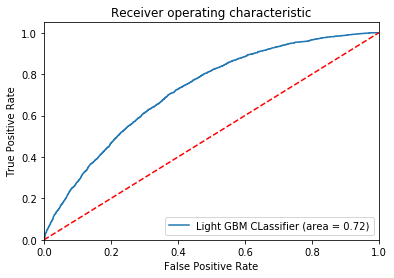

In [94]:
# PREDICTION on LGBM classifer
ypred = clf.predict(xtest)

# F1-SCORE, ACCURACY
print("f1_score:",f1_score(ytest, ypred))                       # calculating f1 score
print("Accuracy on train data:",clf.score(xtrain,ytrain))
print("Accuracy on test data:",clf.score(xtest,ytest))

# CLASSIFICATION REPORT
print(classification_report(ytest,ypred))

# CONFUSION MATRIX
print(pd.crosstab(ypred,ytest))

ypred = clf.predict_proba(xtest)[::,1]                 # predicting on the validation set
auc = roc_auc_score(ytest, ypred)
print(auc)
fpr, tpr, thresholds = roc_curve(ytest, ypred)
plt.figure()
plt.plot(fpr, tpr, label='Light GBM CLassifier (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate'), plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

In [95]:
clf

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               importance_type='split', learning_rate=0.05, max_depth=8,
               min_child_samples=20, min_child_weight=2, min_split_gain=0.01,
               n_estimators=2000, n_jobs=-1, num_leaves=40, objective=None,
               random_state=None, reg_alpha=0.1, reg_lambda=0.1, silent=-1,
               subsample=0.9, subsample_for_bin=200000, subsample_freq=0)

* So, AUC slightly goes over 0.72, though if we see f1 score is close to zero. On the other hand Logistic regression is giving f1 score of 0.14 approx with almost same area under the curve. Maybe we need to optimize paramters of LGBM more or it is overfitting here.
* So, moving forward we'll keep Logitic Regression as our backend plan

#### 8.3) xgBoost

In [96]:
from operator import itemgetter
import xgboost as xgb

s = time.time()
train = df_final_com.iloc[:237609,:]
xtrain, xtest, ytrain, ytest = train_test_split(train, df_train['is_click'].values.ravel(), random_state=42, test_size=0.2)

clf = xgb.XGBClassifier(objective = "binary:logistic",
                        booster = "gbtree",
                        learning_rate = 0.3,
                        eval_metric= "logloss",
                        n_estimators = 100,
                        max_depth= 5,
                        subsample= 0.9,
                        colsample_bytree= 0.9,
                        silent= 1,
                        seed= 0,
                        random_state= 29,
                        num_boost_round= 500,
                        early_stopping_rounds= 100)
clf.fit(
    xtrain, ytrain, 
    eval_set= [(xtrain, ytrain), (xtest, ytest)], 
    eval_metric='auc',verbose=100, early_stopping_rounds=100)
e = time.time()
e-s

[0]	validation_0-auc:0.669451	validation_1-auc:0.667962
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[99]	validation_0-auc:0.779631	validation_1-auc:0.716584


201.8646183013916

f1_score: 0.002788104089219331
Accuracy on train data: 0.9544050881964574
Accuracy on test data: 0.9548419679306427
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     45384
           1       0.21      0.00      0.00      2138

    accuracy                           0.95     47522
   macro avg       0.58      0.50      0.49     47522
weighted avg       0.92      0.95      0.93     47522

col_0      0     1
row_0             
0      45373  2135
1         11     3
0.7165837642884243


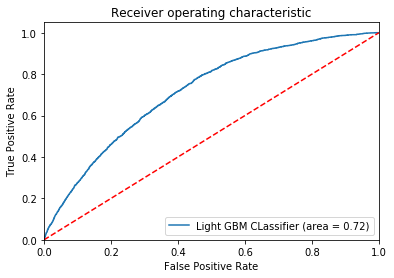

In [97]:
# PREDICTION on XGB classifer
ypred = clf.predict(xtest)

# F1-SCORE, ACCURACY
print("f1_score:",f1_score(ytest, ypred))                       # calculating f1 score
print("Accuracy on train data:",clf.score(xtrain,ytrain))
print("Accuracy on test data:",clf.score(xtest,ytest))

# CLASSIFICATION REPORT
print(classification_report(ytest,ypred))

# CONFUSION MATRIX
print(pd.crosstab(ypred,ytest))


ypred = clf.predict_proba(xtest)[::,1]                 # predicting on the validation set
auc = roc_auc_score(ytest, ypred)
print(auc)
fpr, tpr, thresholds = roc_curve(ytest, ypred)
plt.figure()
plt.plot(fpr, tpr, label='Light GBM CLassifier (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate'), plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

In [128]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.9, early_stopping_rounds=100,
              eval_metric='logloss', gamma=0, learning_rate=0.3,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=50, n_jobs=1, nthread=None, num_boost_round=500,
              objective='binary:logistic', random_state=29, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=0, silent=1,
              subsample=0.9)

* I didn't use grid/random search to hypertuned, as with so many paramters to be tuned in XGB, my laptop was crashing here. So I tried to tuned these paramters manually. And XGB classifier is also not helping much in increaing AUC. Eventually f1-socre is approximately zero here. As we've seen in LGBM classifier. So, Logistic Regression is still winner here.

#### 8.4) Random Forest

In [165]:
n_estimators = [10, 50,100]
max_depth = [15, 20, 25]
min_samples_split = [10, 20, 30]
min_samples_leaf = [10, 20] 

train = df_final_com.iloc[:237609,:]
xtrain, xtest, ytrain, ytest = train_test_split(train, df_train['is_click'].values.ravel(), random_state=42, test_size=0.2)

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

model = RandomForestClassifier(random_state=29)
gridF = GridSearchCV(model, hyperF, verbose = 1,scoring='roc_auc', n_jobs = -1)
bestF = gridF.fit(xtrain, ytrain)

(190087, 173) (47522, 173) (190087,) (47522,)
2138
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 26.9min finished


In [166]:
bestF.best_score_, bestF.best_params_

(0.7115537127101522,
 {'max_depth': 25,
  'min_samples_leaf': 10,
  'min_samples_split': 30,
  'n_estimators': 100})

In [167]:
means = bestF.cv_results_['mean_test_score']
stds = bestF.cv_results_['std_test_score']
params = bestF.cv_results_['params']
for m,s,p in zip(means,stds,params):
    print(m,s,p)

0.6917400990778557 0.0016387072702992033 {'max_depth': 15, 'n_estimators': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}
0.7056047135119501 0.0011988846962139629 {'max_depth': 15, 'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 10}
0.7069118101605862 0.0010530426514245223 {'max_depth': 15, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 10}
0.6917400990778557 0.0016387072702992033 {'max_depth': 15, 'n_estimators': 10, 'min_samples_split': 20, 'min_samples_leaf': 10}
0.7056047135119501 0.0011988846962139629 {'max_depth': 15, 'n_estimators': 50, 'min_samples_split': 20, 'min_samples_leaf': 10}
0.7069118101605862 0.0010530426514245223 {'max_depth': 15, 'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 10}
0.6933158672289622 0.0013646290856910487 {'max_depth': 15, 'n_estimators': 10, 'min_samples_split': 30, 'min_samples_leaf': 10}
0.705457897522765 0.000785054914913935 {'max_depth': 15, 'n_estimators': 50, 'min_samples_split': 30, 

* In **simple_model** section, AUC was only 0.60, however after hypertuning of random forest, it is doing significantly better. Though AUC is around 0.71 only

In [101]:
s = time.time()
train = df_final_com.iloc[:237609,:]
xtrain, xtest, ytrain, ytest = train_test_split(train, df_train['is_click'].values.ravel(), random_state=42, test_size=0.2)
model = RandomForestClassifier(n_estimators=100,
                               class_weight='balanced',
                               max_depth=20,
                               min_samples_split=30,
                               min_samples_leaf=10,
                               random_state=29)
model.fit(xtrain, ytrain)
e = time.time()
e-s

57.79344463348389

f1_score: 0.14693923650327537
Accuracy on train data: 0.7028518520466944
Accuracy on test data: 0.6821261731408611
              precision    recall  f1-score   support

           0       0.97      0.69      0.80     45384
           1       0.08      0.61      0.15      2138

    accuracy                           0.68     47522
   macro avg       0.53      0.65      0.48     47522
weighted avg       0.93      0.68      0.78     47522

col_0      0     1
row_0             
0      31115   837
1      14269  1301
Area Under the Curve: 0.7109065627196721


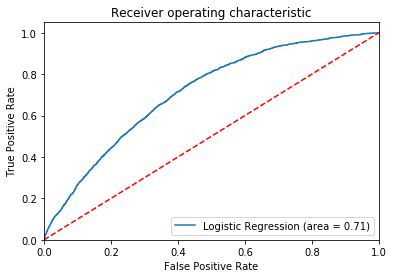

In [102]:
# PREDICTION
ypred = model.predict(xtest)

# F1-SCORE, ACCURACY
print("f1_score:",f1_score(ytest, ypred))                       # calculating f1 score
print("Accuracy on train data:",model.score(xtrain,ytrain))
print("Accuracy on test data:",model.score(xtest,ytest))

# CLASSIFICATION REPORT
print(classification_report(ytest,ypred))

# CONFUSION MATRIX
print(pd.crosstab(ypred,ytest))

# AUC & ROC
ypred = model.predict_proba(xtest)[::,1]                 # predicting on the validation set
auc = roc_auc_score(ytest, ypred)
print("Area Under the Curve:",auc)
fpr, tpr, thresholds = roc_curve(ytest, ypred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate'), plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

* So, arra under the curve here is 0.71 with f1-socre of 0.14
* Seems like we got a tie here, as logistic regression & random forest both giving approx same f1-score & AUC, though logistic regression is giving slighly good AUC. Next, we'll try LDA & resampling with both this models & we'll see how it performs

### 9.) Linear Discriminant Analysis (LDA) (with logistic regression & random forest)

In [106]:
# LDA with Logistic Regression
train = df_final_com.iloc[:237609,:]
xtrain, xtest, ytrain, ytest = train_test_split(train, df_train['is_click'].values.ravel(), random_state=42, test_size=0.2)

lda = LinearDiscriminantAnalysis(n_components=173)
X_train = lda.fit_transform(xtrain, ytrain)
X_test = lda.transform(xtest)

model = LogisticRegression(C=0.9, class_weight='balanced',penalty='l2')
model.fit(X_train, ytrain)

# F1-SCORE
ypred = model.predict(X_test)
print("f1_score:",f1_score(ytest, ypred))                       # calculating f1 score

# AUC
ypred = model.predict_proba(X_test)[::,1]
auc = roc_auc_score(ytest, ypred)
print("Area under the Curve:",auc)

f1_score: 0.14669742984385897
Area under the Curve: 0.7122817831234788


In [108]:
# LDA with Random Forest
train = df_final_com.iloc[:237609,:]
xtrain, xtest, ytrain, ytest = train_test_split(train, df_train['is_click'].values.ravel(), random_state=42, test_size=0.2)

lda = LinearDiscriminantAnalysis(n_components=173)
X_train = lda.fit_transform(xtrain, ytrain)
X_test = lda.transform(xtest)

model = RandomForestClassifier(n_estimators=20,
                               class_weight='balanced',
                               max_depth=3,
                               min_samples_split=15,
                                min_samples_leaf=10,
                               random_state=29)
model.fit(X_train, ytrain)

# F1-SCORE
ypred = model.predict(X_test)
print("f1_score:",f1_score(ytest, ypred))                       # calculating f1 score

# AUC
ypred = model.predict_proba(X_test)[::,1]
auc = roc_auc_score(ytest, ypred)
print("Area under the Curve:",auc)

f1_score: 0.1359165677463117
Area under the Curve: 0.7116437292530207


* So, LDA is also not helping, but if you see logistic regression is giving slightly better f1-socre & area under the curve comparing random forest

### 10) Resampling technique

In [109]:
temp = df_com1.merge(df_com6,how='left',on='impression_id').drop(['impression_id','is_click'],axis=1)
temp['is_click'] = df_com['is_click']
temp.shape

(328284, 435)

In [111]:
# temp = df_com1.merge(df_com6,how='left',on='impression_id').drop(['impression_id'],axis=1)
train = temp.iloc[:237609,:]
test = temp.iloc[237609:,:]

not_deliq = train[train['is_click']==0]
deliq = train[train['is_click']==1]

not_deliq_downsampled = resample(not_deliq, replace = False, n_samples = int(not_deliq.shape[0]*0.3), random_state = 27)
print(deliq['is_click'].value_counts(), not_deliq['is_click'].value_counts(), not_deliq_downsampled['is_click'].value_counts())

df2 = deliq.append(not_deliq_downsampled, ignore_index=True)
df2['is_click'] = df2['is_click'].astype(int)
print(df2.shape, df2.columns)
df2['is_click'].value_counts()

1    10862
Name: is_click, dtype: int64 0    226747
Name: is_click, dtype: int64 0    68024
Name: is_click, dtype: int64
(78886, 435) Index(['is_4G', 'app_code1_0', 'app_code1_2', 'app_code1_3', 'app_code1_5',
       'app_code1_7', 'app_code1_9', 'app_code1_14', 'app_code1_16',
       'app_code1_29',
       ...
       'PT_9839.0', 'PT_986.0', 'PT_9939.0', 'PT_9959.0', 'android', 'iphone',
       'web', 'item_price2', 'flag2', 'is_click'],
      dtype='object', length=435)


0    68024
1    10862
Name: is_click, dtype: int64

In [112]:
train = df2.drop('is_click',axis=1)

xtrain, xtest, ytrain, ytest = train_test_split(train, df2['is_click'].values.ravel(), random_state=42, test_size=0.2)
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)
print(ytest.sum())

# model = ExtraTreesClassifier()
model = LogisticRegression(C=0.8,penalty='l2',class_weight='balanced')
# model = LogisticRegression(C=0.9,penalty='l2',class_weight='balanced')
model.fit(xtrain, ytrain)


(63108, 434) (15778, 434) (63108,) (15778,)
2140


LogisticRegression(C=0.8, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

f1_score: 0.3356397583745195
Accuracy on train data: 0.6219021360207898
Accuracy on test data: 0.6166180758017493
              precision    recall  f1-score   support

           0       0.93      0.60      0.73     13638
           1       0.22      0.71      0.34      2140

    accuracy                           0.62     15778
   macro avg       0.57      0.66      0.53     15778
weighted avg       0.83      0.62      0.68     15778

col_0     0     1
row_0            
0      8201   612
1      5437  1528
Area under the Curve: 0.7135419793238518


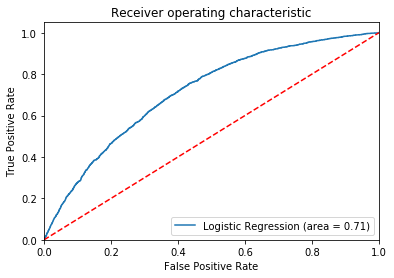

In [117]:
# PREDICTION
ypred = model.predict(xtest)

# F1-SCORE, ACCURACY
print("f1_score:",f1_score(ytest, ypred))                       # calculating f1 score
print("Accuracy on train data:",model.score(xtrain,ytrain))
print("Accuracy on test data:",model.score(xtest,ytest))

# CLASSIFICATION REPORT
print(classification_report(ytest,ypred))

# CONFUSION MATRIX
print(pd.crosstab(ypred,ytest))

# AUC & ROC
from sklearn.metrics import roc_auc_score, roc_curve
ypred = model.predict_proba(xtest)[::,1]
auc = roc_auc_score(ytest, ypred)
print("Area under the Curve:",auc)
fpr, tpr, thresholds = roc_curve(ytest, ypred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate'), plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

* f1-score is significantly **increased** from 0.14 to 0.33; but AUC is come down by a notch (0.715 to 0.713).
* That only means that undersampling is causing in incremant of f1-score for minority class, as we had dropped the data around 70% for majority class.
* Finally, even if resampling is not helping here.

### 11) Final best fitted model
* Logistic Regression (with highest f1-score & AUC)

In [124]:
s = time.time()

train = df_final_com.iloc[:237609,:]
test = df_final_com.iloc[237609:,:]
ytrain = df_train['is_click'].values.ravel()

print(train.shape,test.shape,ytrain.shape)
model = LogisticRegression(C=0.9,penalty='l2',class_weight='balanced',random_state=29)
model.fit(train, ytrain)

e = time.time()
print("Time taken (in seconds)",e-s)

(237609, 174) (90675, 174) (237609,)
Time taken (in seconds) 26.086240530014038


In [125]:
# Predicting on test data

test = df_final_com.iloc[237609:,:]
prediction_int = model.predict_proba(test)[::,1]         # predicting on the validation set

df_sample_submission = pd.read_csv('sample_submission.csv')
df_sample_submission['is_click'] = list(prediction_int)
df_sample_submission.head()

,impression_id,is_click
0,a9e7126a585a69a32bc7414e9d0c0ada,0.460692
1,caac14a5bf2ba283db7708bb34855760,0.127339
2,13f10ba306a19ce7bec2f3cae507b698,0.565580
3,39c4b4dc0e9701b55a0a4f072008fb3f,0.220120
4,bf5a572cca75f5fc67f4b14e58b11d70,0.650081


In [126]:
df_sample_submission.to_csv('submission_file.csv',index=False)

Logistic Regression(0.85,l2,balanced) | All data (5,15)

#### Key notes

* The best metric to use in this case is probably logarithmic loss, which is commonly used when you care about having well-calibrated probabilities. In addition, you might inspect the ROC curve and compute other metrics such as the F1-score and AUC